# Why convolutions?

## Computational reasons
1. Sparse computation (compared to full deep networks)
2. Shared parameters (only a small number of shared parameters)
3. Translation invariance

# 1D convolutions, similar but slightly different than signal processing / math convolutions
## [ -1, 1] filter/kernel highlights "sharp points" of signal

Filter
tensor([-1.,  1.])
x.size torch.Size([300]) y.size torch.Size([299])


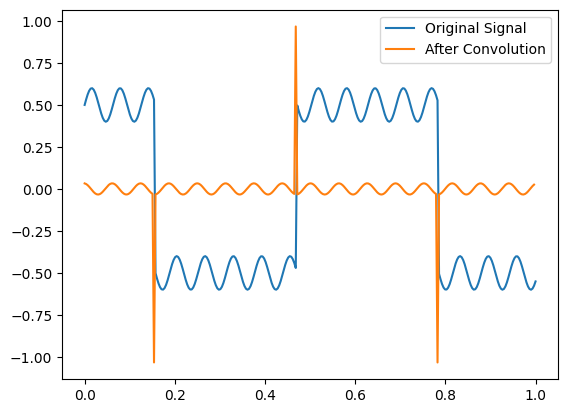

In [1]:
import torch
import matplotlib.pyplot as plt

t = torch.linspace(0, 1.0, 300)
x = (torch.cos(10*t) > 0.0).float() + 0.1*torch.sin(100*t)-0.5
plt.plot(t.numpy(), x.numpy(), label='Original Signal')

from torch.nn import functional as F
filt = torch.tensor([-1, 1.0])
print('Filter')
print(filt)
# Should have shape $(m, c, w)$ where m is minibatch size, c is # channels and w is width
y = F.conv1d(x.reshape(1, 1, len(x)), filt.reshape(1, 1, len(filt))).squeeze_()

print('x.size', x.size(), 'y.size', y.size())
plt.plot(t.numpy()[:len(y)], y.numpy(), label='After Convolution')
plt.legend()

# 2D convolutions are similar and can be applied to images

## Different filters extract different features from the image

Filter
tensor([[-1.,  0.,  1.],
        [-1.,  0.,  1.],
        [-1.,  0.,  1.]])
A size torch.Size([427, 640]) B size torch.Size([214, 320])


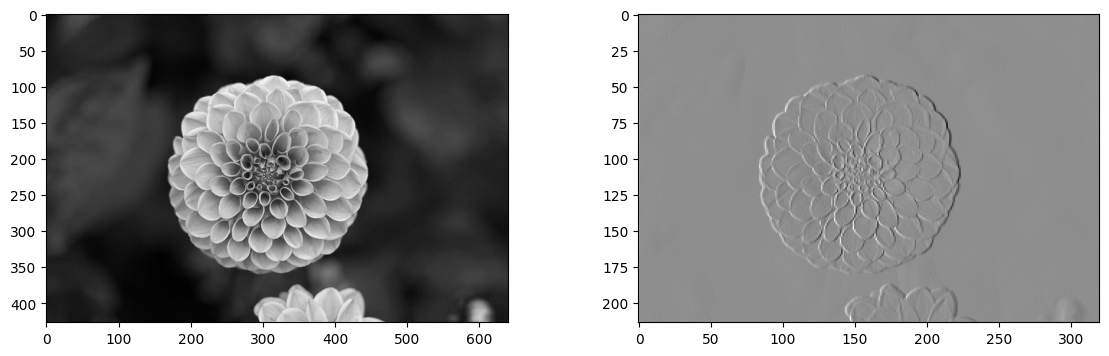

In [2]:
import sklearn.datasets
A = torch.tensor(sklearn.datasets.load_sample_image('flower.jpg')).float()
A = torch.sum(A, dim=2) # Sum channels

filt = torch.tensor([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]]).float() # Horizontal
# filt = torch.tensor([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]]).float().t() # Vertical
# filt = torch.tensor([[1, -1], [-1, 1]]).float() # Checker board pattern
# filt = torch.ones((10, 10)).float() # Blur
print('Filter')
print(filt)
# B = F.conv2d(A.reshape(1, 1, *A.size()), filt.reshape(1, 1, *filt.size())).squeeze()
# B = F.conv2d(A.reshape(1, 1, *A.size()), filt.reshape(1, 1, *filt.size()), padding=1).squeeze()
B = F.conv2d(A.reshape(1, 1, *A.size()), filt.reshape(1, 1, *filt.size()), padding=1, stride=2).squeeze()
print('A size', A.size(), 'B size', B.size())

fig, axes = plt.subplots(1, 2, figsize=(14,4))
axes[0].imshow(A.numpy(), cmap='gray')
axes[1].imshow(B.numpy(), cmap='gray')

# Higher dimensional convolutions are similar (i.e., if there is more than 1 channel)

torch.Size([3, 427, 640])
Filter
tensor([[[1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.]],

        [[1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.]],

        [[1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.]]])
torch.Size([3, 5, 5])
A size torch.Size([3, 427, 640]) B size torch.Size([423, 636])


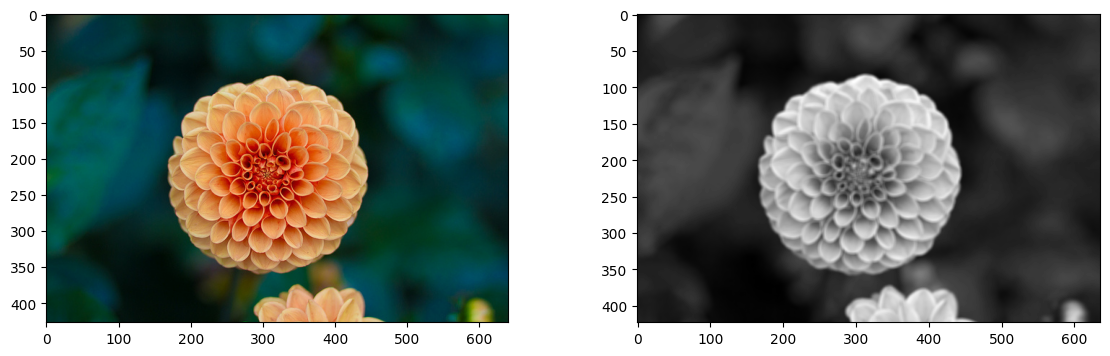

In [3]:
A = torch.tensor(sklearn.datasets.load_sample_image('flower.jpg')).float()
A = A/255
A = A.permute(2,0,1)
print(A.size())

filt = torch.tensor([1, 0, 0]).reshape(3, 1, 1).float() # Extract red
filt = torch.tensor([0, 1, 0]).reshape(3, 1, 1).float() # Extract green
filt = torch.tensor([0, 0, 1]).reshape(3, 1, 1).float() # Extract blue
filt = torch.ones(3, 5, 5).float() # Blur

print('Filter')
print(filt)
print(filt.size())
B = F.conv2d(A.reshape(1, *A.size()), filt.reshape(1, *filt.size())).squeeze()
print('A size', A.size(), 'B size', B.size())

fig, axes = plt.subplots(1, 2, figsize=(14,4))
axes[0].imshow(A.permute(1,2,0), cmap='gray')
axes[1].imshow(B, cmap='gray')

# Need several other components for extracting features: Activation functions and pooling layers

# Why activation functions? Activation functions enable non-linear models
## Consider a deep linear network

In [4]:
torch.manual_seed(0)
A1 = torch.randn((10, 5))
A2 = torch.randn((10, 10))
A3 = torch.randn((1, 10))

x = torch.randn(5)
print('x', x)
y = torch.matmul(A1, x)
y = torch.matmul(A2, y)
y = torch.matmul(A3, y)
print('y', y)

b = torch.matmul(A3, torch.matmul(A2, A1))
y2 = torch.matmul(b, x)
print('y2', y2)

x tensor([ 1.4875, -0.2230, -1.0057, -0.4139,  1.1600])
y tensor([4.1752])
y2 tensor([4.1752])


# If you add activation functions, the deep function cannot be simplified

In [5]:
torch.manual_seed(0)
A1 = torch.randn((10, 5))
A2 = torch.randn((10, 10))
A3 = torch.randn((1, 10))

x = torch.randn(5)
print('x', x)
y = torch.matmul(A1, x)
y = torch.relu(y)
y = torch.matmul(A2, y)
y = torch.relu(y)
y = torch.matmul(A3, y)
print('y', y)

b = torch.matmul(A3, torch.matmul(A2, A1))
y2 = torch.matmul(b, x)
print('y2', y2)

x tensor([ 1.4875, -0.2230, -1.0057, -0.4139,  1.1600])
y tensor([18.9449])
y2 tensor([4.1752])


# Without ReLU or activation function, the function can only be linear

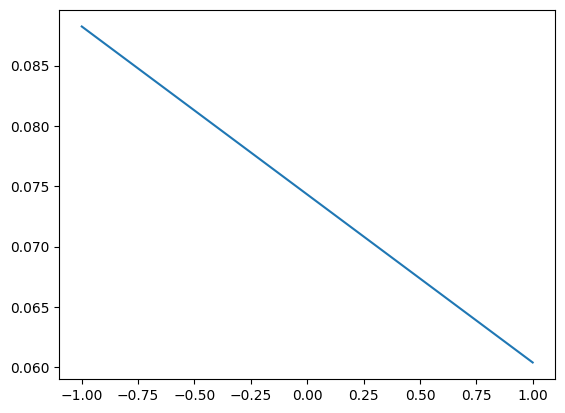

In [6]:
N, D_in, H, D_out = 64, 1, 10, 1
model = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.Linear(H, D_out),
)
x = torch.linspace(-1, 1.0, steps=5).reshape(-1, 1)
y = model(x)
plt.plot(x.detach().numpy(), y.detach().numpy())

# With ReLU activation function, the function is *piecewise* linear

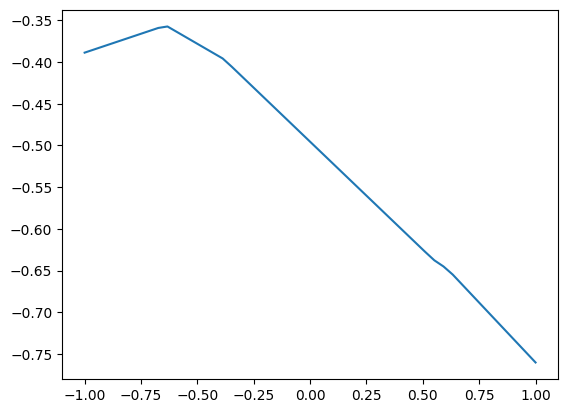

In [7]:
N, D_in, H, D_out = 64, 1, 10, 1
model = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out),
)
x = torch.linspace(-1, 1, steps=50).reshape(-1, 1)
y = model(x)
plt.plot(x.detach().numpy(), y.detach().numpy())

# Common activation functions include sigmoid, ReLU, Leaky ReLU, tanh

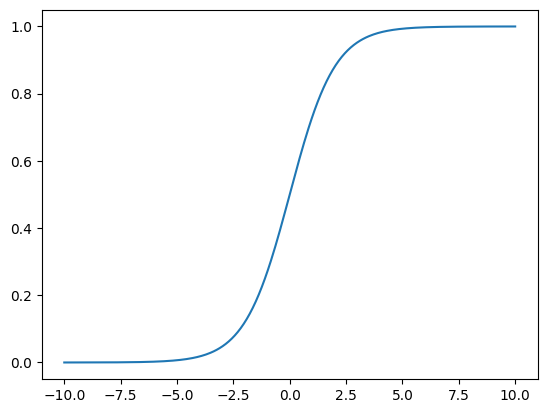

In [8]:
t = torch.linspace(-10, 10, 300)
plt.plot(t.numpy(), torch.sigmoid(t).numpy())

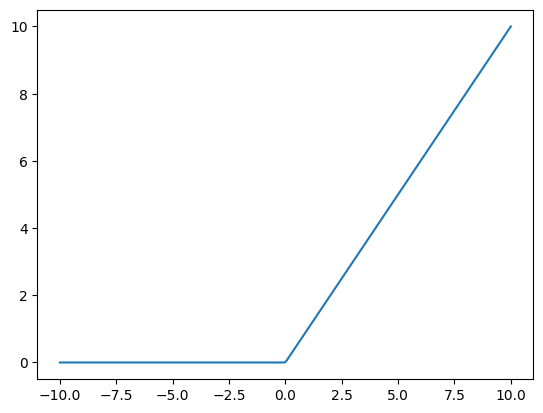

In [9]:
plt.plot(t.numpy(), F.relu(t).numpy())

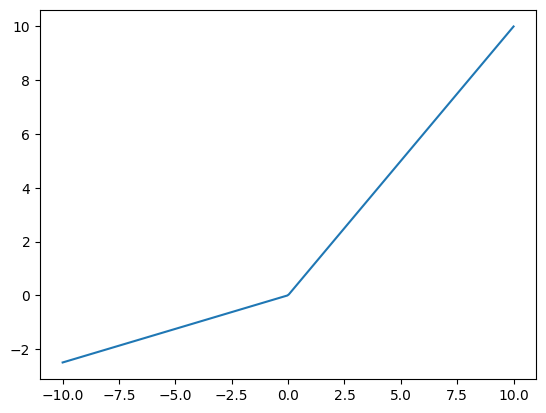

In [10]:
plt.plot(t.numpy(), F.leaky_relu(t, negative_slope=0.25).numpy())

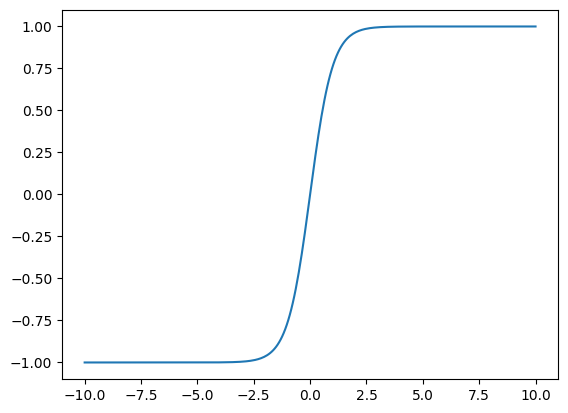

In [11]:
plt.plot(t.numpy(), torch.tanh(t).numpy())

# Pooling layers are used to reduce dimensionality and introduce some location invariance
## Pooling layers include max pooling and average pooling

In [12]:
torch.manual_seed(0)
x = torch.randint(10, (10,)).float()
y = F.max_pool1d(x.reshape(1,1,-1), kernel_size=3)
y2 = F.max_pool1d(x.reshape(1,1,-1), kernel_size=3, stride=1)
y3 = F.max_pool1d(x.reshape(1,1,-1), kernel_size=3, stride=1, padding=1)
#y = F.avg_pool1d(x.reshape(1,1,-1), kernel_size=3)
#y2 = F.avg_pool1d(x.reshape(1,1,-1), kernel_size=3, stride=1)
#y3 = F.avg_pool1d(x.reshape(1,1,-1), kernel_size=3, stride=1, padding=1)
print(x)
print(y)
print(y2)
print(y3)

tensor([4., 9., 3., 0., 3., 9., 7., 3., 7., 3.])
tensor([[[9., 9., 7.]]])
tensor([[[9., 9., 3., 9., 9., 9., 7., 7.]]])
tensor([[[9., 9., 9., 3., 9., 9., 9., 7., 7., 7.]]])


In [13]:
x = torch.randn((3,4,10,20)).float()
print(x.shape, 'N x C x H x W')
y = F.max_pool2d(x, kernel_size=2)
print(y.shape, 'The number of channels does not change for pooling')
y2 = F.max_pool2d(x, kernel_size=2)
print(y2.shape, 'Note that `stride=kernel_size` by default')
y3 = F.max_pool2d(x, kernel_size=2, stride=1)
print(y3.shape, 'Can set stride explicitly to 1')
y4 = F.max_pool2d(x, kernel_size=3, stride=1, padding=1)
print(y4.shape, 'Can produce the same size')

torch.Size([3, 4, 10, 20]) N x C x H x W
torch.Size([3, 4, 5, 10]) The number of channels does not change for pooling
torch.Size([3, 4, 5, 10]) Note that `stride=kernel_size` by default
torch.Size([3, 4, 9, 19]) Can set stride explicitly to 1
torch.Size([3, 4, 10, 20]) Can produce the same size


# Convolution Neural Network (CNN) layers are compositions of convolution, activation and pooling
## (See illustration on slide)

Filter
tensor([[-1.,  0.,  1.],
        [-1.,  0.,  1.],
        [-1.,  0.,  1.]])
A size torch.Size([427, 640]) B size torch.Size([1, 1, 425, 638])


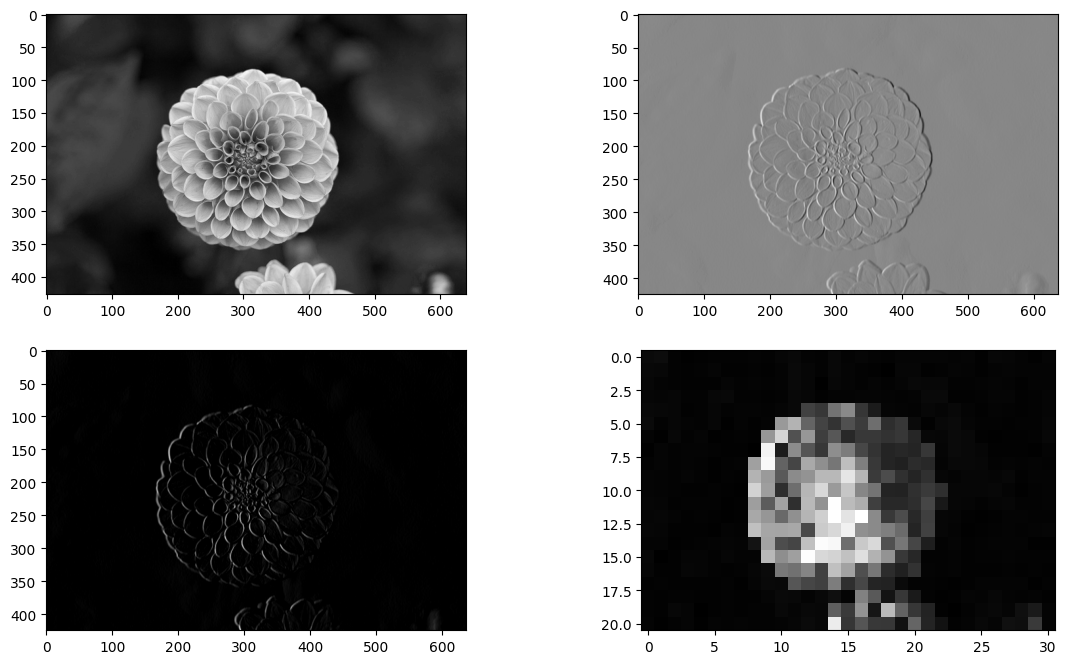

In [14]:
import sklearn.datasets
A = torch.tensor(sklearn.datasets.load_sample_image('flower.jpg')).float()
A = torch.sum(A, dim=2)
filt = torch.tensor([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]]).float() # Horizontal
#filt = torch.tensor([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]]).float().t() # Vertical
#filt = torch.tensor([[1, -1], [-1, 1]]).float() # Checker board pattern
#filt = torch.ones((10, 10)).float() # Blur
print('Filter')
print(filt)
B = F.conv2d(A.reshape(1, 1, *A.size()), filt.reshape(1, 1, *filt.size()))
print('A size', A.size(), 'B size', B.size())
C = torch.relu(B)
D = torch.max_pool2d(C, kernel_size=20)

fig, axes = plt.subplots(2, 2, figsize=(14,8))
axes = axes.ravel()
for im, ax in zip([A, B, C, D], axes):
    ax.imshow(im.squeeze(), cmap='gray')

# How could you detect an edge from multiple angles by combining convolutions and ReLUs?
## Hint: First detect edges from all directions, then combine.

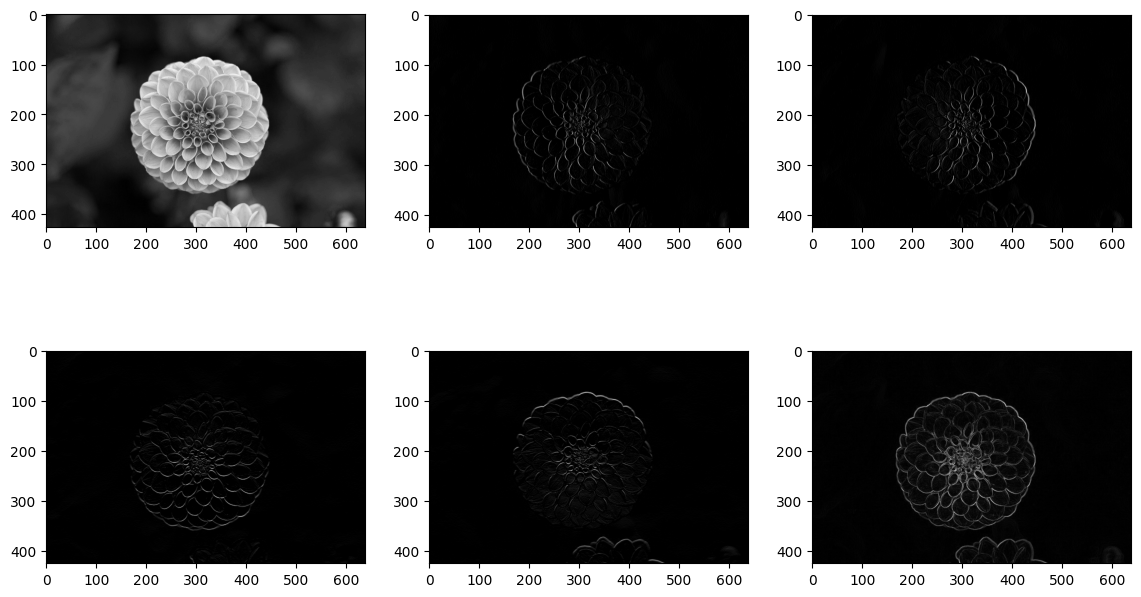

In [15]:
import sklearn.datasets
import torch
import numpy as np
A = torch.tensor(sklearn.datasets.load_sample_image('china.jpg')).float()
A = torch.tensor(sklearn.datasets.load_sample_image('flower.jpg')).float()
A = torch.sum(A, dim=2)

filters = torch.tensor([
    [[[-1, 1], [-1, 1]]],
    [[[1, -1], [1, -1]]],
    [[[1, 1], [-1, -1]]],
    [[[-1, -1], [1, 1]]],
]).float()
B = F.conv2d(A.reshape(1, 1, *A.size()), filters)
C = torch.relu(B)

# Combine
filt = torch.ones(4).float()
D = F.conv2d(C, filt.reshape(1, 4, 1, 1))

fig, axes = plt.subplots(2, 3, figsize=(14,8))
for im, ax in zip([A, *C[0,:,:,:], D], axes.ravel()):
    ax.imshow(im.squeeze(), cmap='gray')

# Check out PyTorch tutorial on simple classifier on CIFAR10 dataset:
https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html